Here we see that small learning rate won't help!!!

In [3]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
%load_ext autoreload
%autoreload 2


from misc import Prob, Basics
import matplotlib.pyplot as plt
basics = Basics(dolinar_layers=2)
ats = basics.ats

def pn1(n,beta,alpha=0.4):
    p=0
    for pm in [-1,1]:
        p+=Prob(pm*alpha, beta,n)
    return p/2

def Q2(b1,n1,b2,alpha=0.4):
    p=0
    for n2 in [0,1]:
        p+=max([Prob(pm*alpha*np.cos(ats[0]), b1,n1)*Prob(pm*alpha*np.sin(ats[0]), b2,n2) for pm in [-1.,1.]])
    p/=pn1(n1,b1)
    return p/2

def Q1(b1,alpha=0.4):
    p=0
    for n1 in [0,1]:
        p+= max([Q2(b1,n1,b2,alpha) for b2 in np.arange(-1,1,.05)])*pn1(n1,b1)
    return p/2

betas = np.arange(-1,1,.05)

data =[]
labels=[]
labels_all=[]
for b1 in betas:
    p0 = pn1(0,b1)
    n1 = np.random.choice([0,1],p=[p0,1-p0])
    for b2 in betas:
        label2 = Q2(b1,n1,b2)
        labels_all.append([label2])
        data.append([[b1,-1.],[b2,n1]])
        labels.append(label2)

        
labels=np.array(labels).astype(np.float32)
data_all = np.reshape(data, (len(data),2,2)).astype(np.float32)
labels_all = np.reshape(labels_all, (len(labels),1))
np.save("data",data_all)
np.save("data",labels)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from glob import glob
len(glob("logs/scalars/training/*"))

2

In [33]:
data_all, labels_all = np.load("ProfilesSet/data.npy"),  np.load("ProfilesSet/label.npy")
dat_set = tf.data.Dataset.from_tensor_slices((data_all,labels_all))
data_all_test=tf.convert_to_tensor(data_all)
labels_all_test = tf.convert_to_tensor(labels_all)

In [19]:
from nets import RNNC
net = RNNC()
optimizer = tf.keras.optimizers.Adam(lr=10**-5)


if not os.path.exists("logs"):
    os.makedirs("logs")
logdir1 = "logs/scalars/training"
logdir2 = "logs/scalars/testing"
train_loss = tf.summary.create_file_writer(logdir1)
test_loss = tf.summary.create_file_writer(logdir2)

In [40]:
32*50

1600

In [38]:
len(list(dat_set.batch(32)))

50

In [20]:
@tf.function
def train_step(data, labels):
    with tf.GradientTape() as tape:
        tape.watch(net.trainable_variables)
        preds = net(tf.convert_to_tensor(data))
        loss = tf.losses.mean_squared_error(tf.squeeze(labels),tf.squeeze(preds))
        grads = tape.gradient(loss, net.trainable_variables)
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    return loss

In [21]:
#dat_set.shuffle(buffer_size=10**4)
l=[]
#lt=[]
for k in tqdm(range(10**3)):
    l.append(train_step(data_all, labels_all))
    with train_loss.as_default():
        tf.summary.scalar('train_loss', l[-1], step=k)
    with test_loss.as_default():
        tf.summary.scalar('test_loss', tf.reduce_mean(tf.keras.losses.MSE(net(data_all_test),labels_all_test)), step=k)
    #lt.append()
    #for k1,k2 in list(dat_set.batch(64)):
    #    l.append(train_step(k1,k2).numpy())    
    #    lt.append(lt[-1])

100%|██████████| 1000/1000 [00:25<00:00, 38.99it/s]


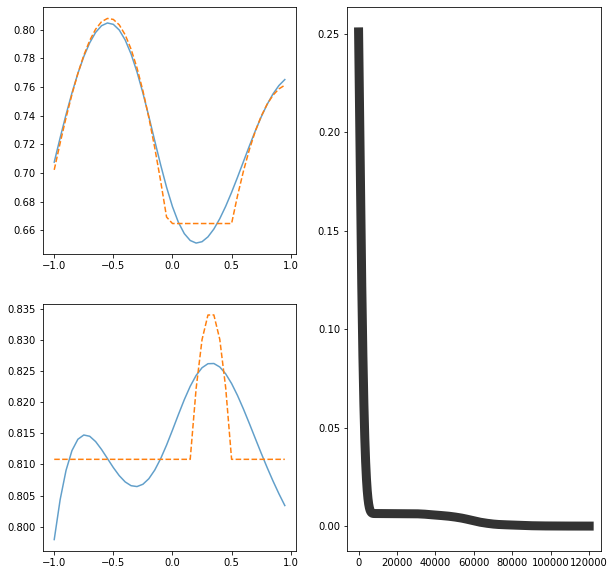

In [47]:
        
b1=-.5
plt.figure(figsize=(10,10))
ax1=plt.subplot2grid((2,2),(0,0))
ax2=plt.subplot2grid((2,2),(1,0))
ax3=plt.subplot2grid((2,2),(0,1),rowspan=2)

axs = [ax1,ax2]
data_test = {}
for nn,ax in zip([0.,1.],axs):
    data_test[str(nn)] = []
    for b in betas:
        data_test[str(nn)].append([[b1,-1.],[b,nn]])
    ax.plot(betas, np.squeeze(net(np.reshape(data_test[str(nn)], (len(data_test[str(nn)]), 2,2)))), alpha=0.7)
    ax.plot(betas, [Q2(b1,nn,b) for b in betas], '--', label="Q2")
ax3.plot(l, color="black", linewidth=9, alpha=.8)
ax3.plot(range(len(lt)), lt,color="blue", linewidth=9, alpha=.8, label="globl")

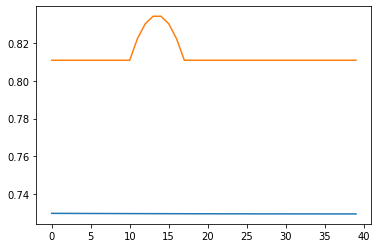

In [42]:
dd,ll=[],[]
n1=1
b1=.5
dd=[]
for b2 in betas:
    ll.append(Q2(b1,n1,b2))
    dd.append([[b1,-1.],[b2,n1]])

plt.plot(np.squeeze(net(np.array(dd))))
plt.plot(ll)

In [43]:
tf.keras.losses.MSE(ll,np.squeeze(net(np.array(dd))))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0070641725>